<a href="https://colab.research.google.com/github/gnitnaw/Programs/blob/master/Chapter4/gausthetakde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!python --version

Python 3.7.12


# Example 4.3
## Import modules

In [4]:
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)

1.19.5


## Set random seed

In [5]:
np.random.seed(1234)

## kde function

In [6]:
def kde(data, n=2**14, MIN=None, MAX=None, plot=False, label = []):
#==============================================================================
# Reliable and extremely fast kernel density estimator for one-dimensional data;
#        Gaussian kernel is assumed and the bandwidth is chosen automatically;
#        Unlike many other implementations, this one is immune to problems
#        caused by multimodal densities with widely separated modes (see example). The
#        estimation does not deteriorate for multimodal densities, because we never assume
#        a parametric model for the data.
# INPUTS:
#     data    - a vector of data from which the density estimate is constructed;
#          n  - the number of mesh points used in the uniform discretization of the
#               interval [MIN, MAX]; n has to be a power of two; if n is not a power of two, then
#               n is rounded up to the next power of two, i.e., n is set to n=2^ceil(log2(n));
#               the default value of n is n=2^12;
#   MIN, MAX  - defines the interval [MIN,MAX] on which the density estimate is constructed;
#               the default values of MIN and MAX are:
#               MIN=min(data)-Range/10 and MAX=max(data)+Range/10, where Range=max(data)-min(data);
#    plot     -  (True/False) whether or not to produce a plot 
#    label    -  (string) label to apply to kde plot 
    
# OUTPUTS:
#   bandwidth - the optimal bandwidth (Gaussian kernel assumed);
#     density - column vector of length 'n' with the values of the density
#               estimate at the grid points;
#     xmesh   - the grid over which the density estimate is computed;
#             - If no output is requested, then the code automatically plots a graph of
#               the density estimate.
#        cdf  - column vector of length 'n' with the values of the cdf
#  Reference: 
# Kernel density estimation via diffusion
# Z. I. Botev, J. F. Grotowski, and D. P. Kroese (2010)
# Annals of Statistics, Volume 38, Number 5, pages 2916-2957. 

#
#  Example:
#              kde(data,2**14,min(data)-5,max(data)+5);
#
#  Notes:   If you have a more reliable and accurate one-dimensional kernel density
#           estimation software, please email me at botev@maths.uq.edu.au

#==============================================================================
    import numpy as np
    from scipy import optimize
	
	# Auxiliary Functions 
    #==========================================================================  
    def fixed_point(t,N,I,a2):
        # This implements the function t-zeta*gamma^[l](t)
        l=7
        f=2*np.pi**(2*l) * sum(I**l*a2*np.exp(-I*np.pi**2*t))
        
        for s in range(l-1,1,-1):
            K0    = np.prod(range(1,2*s,2))/np.sqrt(2*np.pi)
            const = (1+(1/2)**(s+1/2))/3
            time  = (2*const*K0/N/f)**(2/(3+2*s))
            f     = 2*np.pi**(2*s)*sum(I**s*a2*np.exp(-I*np.pi**2*time)) 
        
        return t-(2*N*np.sqrt(np.pi)*f)**(-2/5)
    #==========================================================================  
    def dct1d(data):
        # computes the discrete cosine transform of the column vector data
        nrows = len(data)
        # Compute weights to multiply DFT coefficients
        weight = 2*(np.exp(-1j*np.array(range(1,nrows))*np.pi/(2*nrows)))
        weight = np.append(1,weight)
        # Re-order the elements of the columns of x
        data = np.append(data[::2],data[:0:-2])
        # Multiply FFT by weights:
        data = (weight*np.fft.fft(data)).real
		
        return data
    #==========================================================================  
    def idct1d(data):
		# computes the discrete cosine transform of the column vector data
        nrows = len(data) 
		# Compute weights to multiply DFT coefficients
        weights = nrows*np.exp(1j*(np.arange(nrows))*np.pi/(2*nrows))
		# Multiply FFT by weights:
        data = np.real(np.fft.ifft(weights * data))
        # Re-order the elements of the columns of x
        output = np.arange(nrows, dtype = 'd')
        output[::2] = data[0:int(nrows/2)]
        output[1::2] = data[:int(nrows/2)-1:-1]
		
		#   Reference:
		#     A. K. Jain, "Fundamentals of Digital Image
		#     Processing", pp. 150-153.
		
        return output
		
   # Main Function
   #===========================================================================  
    data = np.array(data)   #Make data a numpy array 
    
    n=int(2**np.ceil(np.log2(n))) #round up n to the next power of 2;
    
	#define the default  interval [MIN,MAX]
    
    if MAX == None or MIN == None:
        minimum = min(data)
        maximum = max(data)
        Range   = maximum - minimum
    
        if MAX == None:
            MAX=maximum+Range/10
        
        if MIN == None:
            MIN=minimum-Range/10
       

	# set up the grid over which the density estimate is computed;
    R=MAX-MIN; dx=R/(n-1)
    xmesh=np.arange(MIN,MAX+dx,dx, dtype = 'd')
    bins = np.append(xmesh, xmesh[-1])
    N=len(np.unique(data))
	# bin the data uniformly using the grid defined above;
    initial_data= np.histogram(data, bins = bins)[0]/N
    initial_data=initial_data/sum(initial_data)

	# discrete cosine transform of initial data
    a=dct1d(initial_data)

	# now compute the optimal bandwidth^2 using the referenced method
    I=np.arange(1,n,dtype = "d")**2; a2=(a[1:]/2)**2

	# solve the equation t=zeta*gamma^[5](t)
    t_star = optimize.root(lambda t: fixed_point(t,N,I,a2), 0.05)
    if t_star.success == False:
        t_star = 0.28*N**(-2/5)
    else: 
        t_star = t_star.x
	# smooth the discrete cosine transform of initial data using t_star
    a_t=a*np.exp(-np.arange(0,n, dtype = "d")**2*np.pi**2*t_star/2)
    
	# now apply the inverse discrete cosine transform
    density=idct1d(a_t)/R
	# take the rescaling of the data into account
    bandwidth=np.sqrt(t_star)*R
    
    # for cdf estimation
    f=2*np.pi**2*sum(I*a2*np.exp(-I*np.pi**2*t_star))
    t_cdf=(np.sqrt(np.pi)*f*N)**(-2/3)
	# now get values of cdf on grid points using IDCT and cumsum function
    a_cdf=a*np.exp(-np.arange(0,n,dtype="d")**2*np.pi**2*t_cdf/2)
    cdf=np.cumsum(idct1d(a_cdf))*(dx/R)
	#take the rescaling into account if the bandwidth value is required
    bandwidth_cdf=np.sqrt(t_cdf)*R

    if plot==True:
        if label: 
            plt.plot(xmesh, density, label = label)
            plt.legend()
        else: 
             plt.plot(xmesh, density)
        plt.ylim(bottom=0)  
      

    return [bandwidth,density,xmesh,cdf]
	#==========================================================================  



## Original program

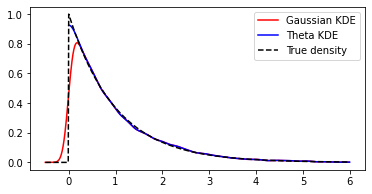

In [7]:
h   = 0.1; h2 = h**2; c=1/np.sqrt(2*np.pi)/h #Constants
phi = lambda x,x0: np.exp(-(x-x0)**2/(2*h2)) #Unscaled Kernel
f   = lambda x: np.exp(-x)*(x >= 0) # True PDF 
n = 10**4 # Sample Size
x = -np.log(np.random.uniform(size=n))# Generate Data via IT method
xx = np.arange(-0.5,6,0.01, dtype = "d")# Plot Range
phis = np.zeros(len(xx))
for i in range(0,n):
    phis = phis + phi(xx,x[i])
phis = c*phis/n

plt.figure(figsize=[6,3])

plt.plot(xx,phis,'r')# Plot Gaussian KDE

[bandwidth,density,xmesh,cdf] = kde(x,2**12,0,max(x))

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
idx = (xmesh <= 6)
plt.plot(xmesh[idx],density[idx],'b')# Plot Theta KDE
plt.plot(xx,f(xx),'k--')# Plot True PDF
plt.legend(['Gaussian KDE','Theta KDE', 'True density'])
plt.savefig('gausthetakde.pdf',format='pdf')
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%